# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя. 

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта ChaLearn Looking at People.

Метрика качества: MAE (mean_absolute_error).  

План выполнения проекта:  

Провести исследовательский анализ данных,  
Обучить модель на GPU-ускорителе  
Провести анализ результата обучения модели.  
*разделение проекта на части обусловлено работой в разной среде (локальный компьютер / сервер с графическим ускорителем)* 

## Исследовательский анализ данных

Импортируем необходимые для работы библиотеки и модули:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

RANDOM_STATE = 42

Выносим функции отдельно:

In [2]:
"""Информация о датафрейме"""
def df_info(dataframe):
    print('Общая информация по датафрейму:')
    display(dataframe.info())
    print('\nПервые 10 строк:')
    display(dataframe.sample(10))
    print('\nПоследние 10 строк:')
    display(dataframe.tail(10))
    print('\nПропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nОписание датафрейма:')
    display(dataframe.describe())
    print('\nЯвные дубликаты:')
    display(df.duplicated().sum())


"""Отрисовка гистораммы с предварительным расчетом"""    
def df_hist(col, xlabel, ylabel, title, rotation=0):
    mean_age = col.mean()
    min_age = col.min()
    max_age = col.max()
        
    plt.figure(figsize=(17,7))
    sns.kdeplot(col, color='#4635FF', shade=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight='bold')
    plt.xticks(rotation=rotation)
    
    plt.axvline(x=mean_age, label=f'средний возраст={int(mean_age)}', lw=1.5, c='#4635FF')
    plt.axvline(x=min_age, label=f'минимальный возраст={int(min_age)}', lw=1.5, c='#4635FF')
    plt.axvline(x=max_age, label=f'максимальный возраст={int(max_age)}', lw=1.5, c='#4635FF')
       
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--');
    

"""Вывод фотографий"""
def print_photo(features, target):
    fig = plt.figure(figsize=(17, 17))
    fig.suptitle('образцы фото', 
                 fontsize=16)
    for i in range(25):
        fig.add_subplot(5, 5, i+1)
        plt.imshow(features[i])
        plt.title(target[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout();

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

Создаём генератор и загружаем фотографии с метками возраста:

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255) 

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


Исследуем датасет:

In [5]:
df_info(df)

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None


Первые 10 строк:


,file_name,real_age
1089,001089.jpg,39
7211,007229.jpg,32
2800,002800.jpg,27
194,000194.jpg,21
5351,005351.jpg,19
4900,004900.jpg,47
5847,005847.jpg,15
6745,006752.jpg,26
4960,004960.jpg,60
5843,005843.jpg,38



Последние 10 строк:


,file_name,real_age
7581,007603.jpg,29
7582,007604.jpg,24
7583,007605.jpg,5
7584,007606.jpg,27
7585,007607.jpg,10
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47



Пропуски:


file_name    0
real_age     0
dtype: int64


Описание датафрейма:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000



Явные дубликаты:


0

Датафрейм содержит два столбца:
 - file_name - название .jpg-файла в хралилице
 - real_age - реальный возраст человека на фото(таргет) -   
и 7591 запись.  
Пропусков в данных нет, явные дубликаты отсутствуют.

Построим график распределения возрастов:

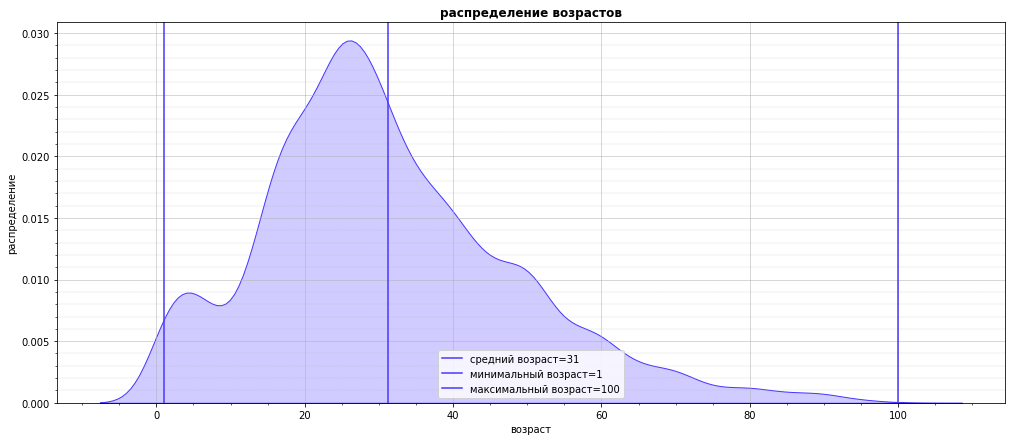

In [6]:
df_hist(df['real_age'], 'возраст', 'распределение', 'распределение возрастов')

Возрастные группы распределены неравномерно. Наибольшее количество людей на фото в возрасте 15 - 40 лет. Большое количество детей в возрасте 1 года и младше.
Средний возраст посетителя «Хлеба-Соли» 31 год. Наибольшее количество в возрастной группе 25-30 лет. Людей старшей возрастной группы явно меньше, можно предположить, что это связано с тем, что они вообще меньше фотографируются, а фотографии, видимо, взяты из открытых источников. Фотографии людей и группы 25-30 лет, возможно просто проще найти и собрать

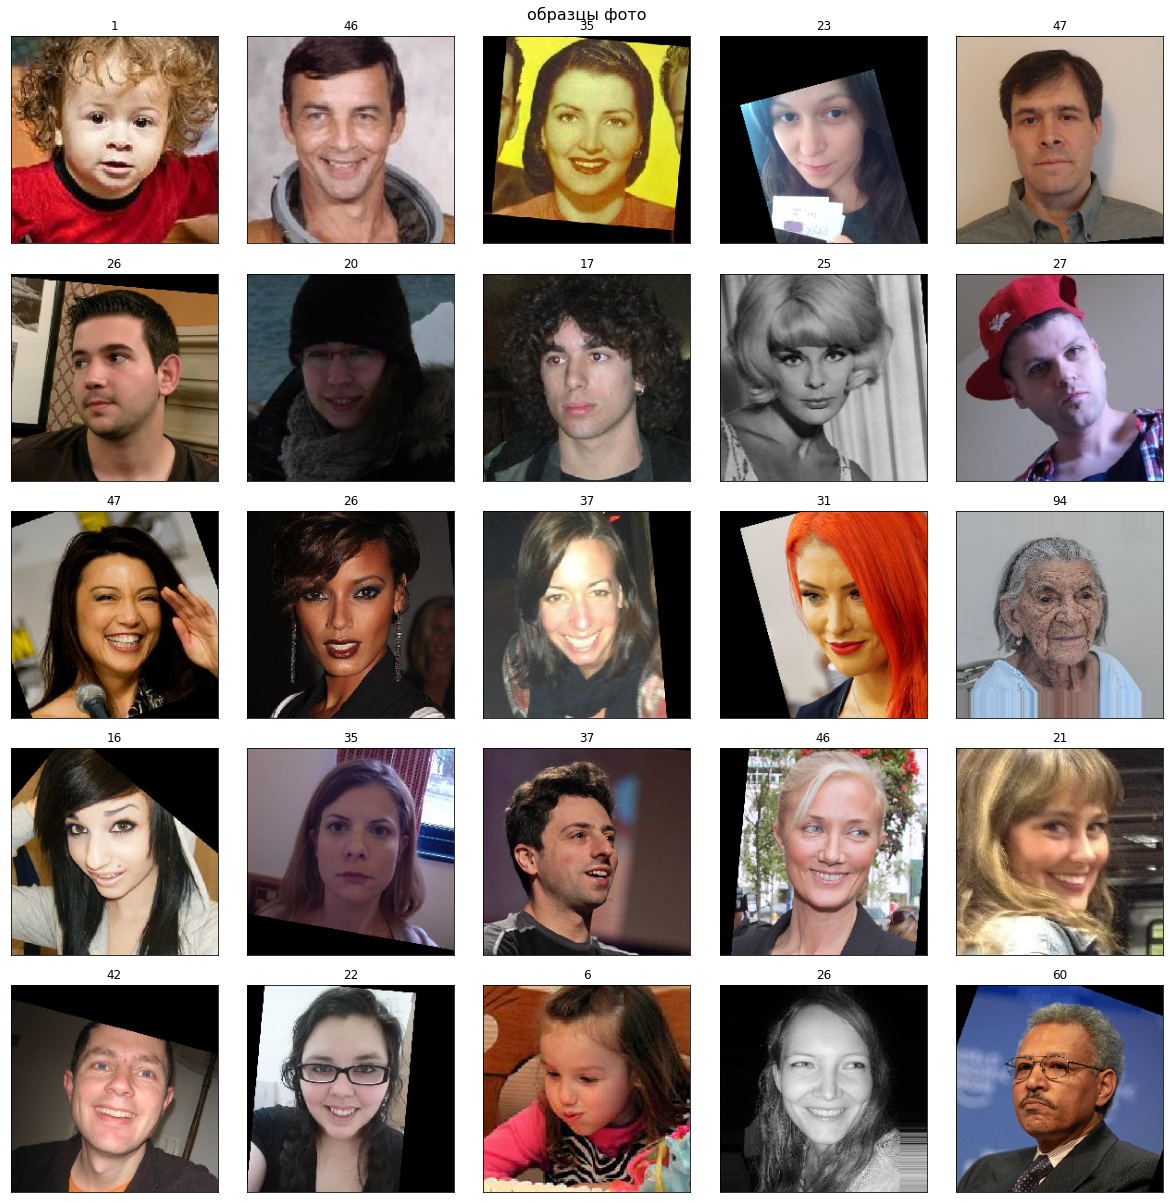

In [7]:
X, y = next(train_gen_flow)
print_photo(X, y)

Метка возраста фотографии примерно соответствует человеку на ней, а значит сильных ошибок возникать не должно.  
Что касается фото, то они самые разные: 
засвеченные, с поворотом на какой-то градус, чёрно-белые и цветные, смазанные, на некоторых есть очки, головные уборы, другие обрезанные люди.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

**Код:**

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
  
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,                              
        rescale=1./255,                              
        horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(    
        dataframe=labels,
        directory=path + 'final_files/',      
        x_col='file_name',      
        y_col='real_age',      
        target_size=(224, 224),      
        batch_size=16,      
        class_mode='raw',      
        subset='training',      
        seed=12345
    )

    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(                                    
        validation_split=0.25,                                    
        rescale=1./255
    )
    
    test_gen_flow = test_datagen.flow_from_dataframe(      
        dataframe=labels,      
        directory=path + 'final_files/',      
        x_col='file_name',      
        y_col='real_age',      
        target_size=(224, 224),      
        batch_size=16,      
        class_mode='raw',      
        subset='validation',      
        seed=12345
    )

    return test_gen_flow


def create_model(input_shape): 
    
    optimizer = Adam(learning_rate = 0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)     
    model = Sequential()     
    model.add(backbone)     
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(1, activation='relu'))    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,              
              validation_data=test_data,              
              batch_size=batch_size, 
              epochs=epochs,              
              steps_per_epoch=steps_per_epoch,              
              validation_steps=validation_steps,              
              verbose=2)

    
    return model

```

**Ниже ячейка с выводом:**

```

Train for 356 steps, validate for 119 steps
Epoch 1/10

356/356 - 52s - loss: 190.7859 - mae: 10.3870 - val_loss: 338.2324 - val_mae: 13.6578
Epoch 2/10
356/356 - 42s - loss: 107.7272 - mae: 7.8414 - val_loss: 239.0990 - val_mae: 11.7719
Epoch 3/10
356/356 - 42s - loss: 84.9532 - mae: 7.0104 - val_loss: 144.5016 - val_mae: 9.0440
Epoch 4/10
356/356 - 42s - loss: 68.0292 - mae: 6.2694 - val_loss: 122.9812 - val_mae: 8.7813
Epoch 5/10
356/356 - 43s - loss: 57.1201 - mae: 5.7720 - val_loss: 183.1959 - val_mae: 10.2590
Epoch 6/10
356/356 - 42s - loss: 47.1739 - mae: 5.2462 - val_loss: 123.2848 - val_mae: 8.1761
Epoch 7/10
356/356 - 42s - loss: 38.7257 - mae: 4.7309 - val_loss: 266.4788 - val_mae: 13.1393
Epoch 8/10
356/356 - 42s - loss: 38.2738 - mae: 4.6923 - val_loss: 101.6819 - val_mae: 7.5006
Epoch 9/10
356/356 - 42s - loss: 28.3262 - mae: 4.0863 - val_loss: 76.9684 - val_mae: 6.5818
Epoch 10/10
356/356 - 42s - loss: 23.8112 - mae: 3.7313 - val_loss: 78.9857 - val_mae: 6.5716


119/119 - 10s - loss: 78.9857 - mae: 6.5716

```

## Анализ обученной модели

По запросу супермаркета «Хлеб-Соль» разработана модель машинного обучения, которая может определять возрастную группу покупателя супермаркета по его фотографии.   

Для реализации задачи были проделаны следующие шаги:  
- изучены предоставленные данные  
- в проекте используется архитектура RasNet50 (с блоками из свёрточных слоёв), предобученная на изображениях и алгоритм обучения нейронной сети Adam.

Модель показала значение метрики MAE равное 6.5716. Грубо говоря, что наша модель может определить возрастную группу покупателя супермаркета с точностью до ±6.57 лет.   
Таким образом получается определить к какой возрастной группе можно отнести человека,что пригодится для формирования рекомендаций списка товаров.   
Для определения совершеннолетия покупателя модель не подойдет, для этой задачи остро необходимо определять возраст. Возможно стоит подумать о постановке задачи классификации для решения этого кейса - младше 18 и старше 18 лет, и затем, если покупатель отнесен к группе младше 18, анализировать, запросил кассир удостоверение личности для проверки возраста или нет.